In [1]:
import pylab
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import tqdm
plt.ioff()

In [2]:
# Function to generate an image of the atomic configuration in the box.
def create_picture(positions):
    plt.figure(figsize=[5,5])
    pylab.cla()
    pylab.axis([0, L, 0, L])
    pylab.setp(pylab.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = pylab.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)

In [3]:
# Function to calculate time it takes for a pair of atoms to collide. 
def pair_time(pos1, vel1, pos2, vel2, rad):  
    rel_pos = pos2 - pos1
    rel_vel = vel2 - vel1
    rel_dist_squar = np.dot(rel_pos,rel_pos)
    rel_speed_squar = np.dot(rel_vel,rel_vel)
    scal_prod = np.dot(rel_pos,rel_vel)
    a = scal_prod ** 2 - rel_speed_squar * ( rel_dist_squar - 4.0 * rad **2)
    if a > 0.0 and scal_prod < 0.0: ## Conditions for collision.
        del_t = - (scal_prod + np.sqrt(a)) / rel_speed_squar ## Collision time.
    else:
        del_t = float('inf')
    return del_t

# Function to compute time for wall collision
def wall_time(coord, velcomp, rad):  
    if velcomp > 0.0:
        del_t = (L - rad - coord) / velcomp
    elif velcomp < 0.0:
        del_t = (coord - rad) / abs(velcomp)
    else:
        del_t = float('inf')
    return del_t

In [4]:
# Function to randomly generate atomic positions   

def randomgen(n,r):
    while True:
        pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 
        pos = np.zeros([n,2],float)
        for i in range(n):
            for j in range(2):
                pos[i,j]=round(random.uniform(r,L-r),2)
        
        pair_dist = [np.linalg.norm(pos[j]-pos[i]) for i,j in pairs] 
        if all(ele > 2*r for ele in pair_dist): # checks if any atom is overlapping another atom
            break
    return pos

# Function to generate atomic positions in a pattern  

def patterngen(n,r):
    pos=np.zeros([n,2],float)

    startx=2*r
    starty=2*r
    pos[0,:]=[startx,starty]

    for i in range(n-1):
        startx+=(L-4*r)/(np.floor(np.sqrt(n))+1)

        if startx>(L-2*r):
            startx=2*r
            starty+=(L-4*r)/(np.floor(np.sqrt(n))+1)

        pos[i+1,:]=[startx,starty]
    return pos

<Figure size 432x288 with 0 Axes>

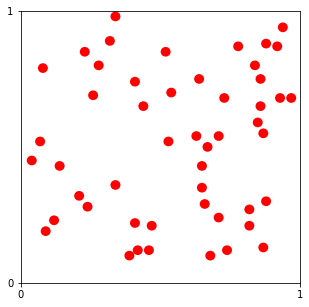

In [5]:
# Initialization of box

L = 1 ## Box edge length
Natoms = 50 #Number of atoms
density = 0.05 # Fraction of area of box occupied by the atoms
Ratom = np.sqrt(density*L**2/(Natoms*np.pi))   ## Radius of an atom.

# Initial Position of the atoms

pos = randomgen(Natoms,Ratom)

# Snapshot of initial position

plt.clf()
create_picture(np.array(pos))
plt.show()

In [6]:
# Initial velocities of atoms

vel=np.zeros([Natoms,2],float)
mean=0.0
sigma=1.0
vel[:,0]=np.random.normal(mean,sigma,Natoms)
vel[:,1]=np.random.normal(mean,sigma,Natoms)
cm_momentum=sum(vel)/Natoms
vel=vel-cm_momentum

In [7]:
t = 0.0 # Initial time.
n_events = 100000 # Number of collision events.

## List indexing all pairs of atoms.
pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 

# Creating arrays for vectors
positions=np.array(pos)
velocities=np.array(vel)

v_list = []

In [ ]:
# Event Loop ~ 20 mins

for event in tqdm(range(n_events)):
    # Wall collision times for all atoms and their velocity components.
    wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)] 
    # Pair collision times
    pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
    # The next collision event is the minimum of wall and pair collision times.
    next_event = min(wall_times + pair_times)  
    t += next_event 
    positions += velocities*next_event # Evolve positions to collision event
    
    if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall
        wall_index = wall_times.index(next_event)
        particle, component = int(wall_index/2), int(wall_index%2)
        velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
    else:
        pair_index = pair_times.index(next_event)
        particle_1, particle_2 = pairs[pair_index] # Indices of atoms participating in collision.
        rel_pos = positions[particle_2] - positions[particle_1]
        rel_vel = velocities[particle_2] - velocities[particle_1]
        distance = np.sqrt(np.dot(rel_pos,rel_pos))
        unit_perp = rel_pos/distance
        scal_prod = np.dot(rel_vel,unit_perp)
        velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
        velocities[particle_2] -= scal_prod*unit_perp

    for v in velocities:
        v_list.append(np.linalg.norm(v))

  6%|▌         | 5756/100000 [01:19<19:47, 79.40it/s] 

In [ ]:
### Function to plot Velocity Distribution
def vel_hist(v_list):
    N, bins, patches = plt.hist(x=v_list, bins='auto', alpha=0.85)
    plt.grid(axis='y', alpha=0.5)
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    plt.title('Velocity Distribution')
    maxfreq = N.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
vel_hist(v_list)